In [1]:
!pip install pandarallel

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.9 MB/s eta 0:00:00
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16673 sha256=ac599636d2dab648b45074dbd8dc85a7871b4499cb1b82ca3a997bbc395142dc
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel


In [2]:
import warnings

warnings.filterwarnings("ignore")

import os
import re
import nltk

nltk.download("wordnet")
nltk.download("stopwords")
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
from nltk.corpus import stopwords
from pandarallel import pandarallel
from torch.utils.data import DataLoader, TensorDataset
from torchtext import vocab
from tqdm import tqdm

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [4]:
train_data = pd.read_csv("/content/training.csv")
val_data = pd.read_csv("/content/validation.csv")
test_data = pd.read_csv("/content/test.csv")

In [5]:
class Preprocessor:
    def __init__(
        self,
        max_length,
        min_freq,
        sos_token,
        eos_token,
        unk_token,
        pad_token,
        shuffle=False,
        batch_size=16,
        stopwords=[]
    ):
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.max_length = max_length
        self.min_freq = min_freq
        self.sos_token = sos_token
        self.eos_token = eos_token
        self.unk_token = unk_token
        self.pad_token = pad_token
        self.stopwords = stopwords

        self.special_tokens = [unk_token, pad_token, sos_token, eos_token]


    def clean(self, data):
        self.nlp = spacy.load("en_core_web_sm")

        lemmatize = lambda text: " ".join(
            x
            for x in map(lambda token: token.lemma_, self.nlp(text))
            if x not in self.stopwords
        )

        print("Lemmatizing...")
        data["clean_text"] = data["text"].parallel_apply(lemmatize).str.lower()
        print("Lemmatizing Done!")

        return data

    def tokenize(self, text, max_length, sos_token, eos_token):
        tokens = [token.text for token in self.nlp.tokenizer(text)][:max_length]
        en_tokens = [sos_token] + tokens + [eos_token]
        return en_tokens

    def convert_numerical(self, tokens):
        en_ids = self.vocab.lookup_indices(tokens)
        return en_ids

    def fit(self, data):

        data = self.clean(data)
        print("Tokenizing Started...")
        data["tokens"] = data["clean_text"].map(
            lambda x: self.tokenize(
                str(x), self.max_length, self.sos_token, self.eos_token
            )
        )
        print("Tokenizing Done!")
        self.vocab = vocab.build_vocab_from_iterator(
            data["tokens"], min_freq=self.min_freq, specials=self.special_tokens
        )
        unk_index = self.vocab[self.unk_token]
        self.vocab.set_default_index(unk_index)

    def pad_sequences(self, sequences, pad_token):
        max_seq_len = self.max_length + 2

        padded_sequences = [
            seq + [pad_token] * (max_seq_len - len(seq)) for seq in sequences
        ]
        return padded_sequences

    def transform(self, data, return_float=True):
        if "clean_text" not in data.columns:
            data = self.clean(data)
        if "tokens" not in data.columns:
            data["tokens"] = data["clean_text"].map(
                lambda x: self.tokenize(
                    str(x), self.max_length, self.sos_token, self.eos_token
                )
            )

        data["numerical_tokens"] = data.tokens.map(self.convert_numerical)

     
        padded_sequences = self.pad_sequences(
            data["numerical_tokens"].to_list(), self.vocab[self.pad_token]
        )

        X = np.array(padded_sequences)
        y = data.label.to_numpy()

        if return_float:
            X_tensor = torch.tensor(X, dtype=torch.float32)
            y_tensor = torch.tensor(y, dtype=torch.float32)
        else:
            X_tensor = torch.tensor(X, dtype=torch.long)
            y_tensor = torch.tensor(y, dtype=torch.long)

        iterable_data = DataLoader(
            dataset=TensorDataset(X_tensor, y_tensor),
            batch_size=self.batch_size,
            shuffle=self.shuffle,
        )

        return iterable_data

In [6]:
%%time

processor = Preprocessor(
    shuffle=True,
    batch_size=32,
    max_length=40,
    min_freq=2,
    sos_token="<sos>",
    eos_token="<eos>",
    unk_token="<unk>",
    pad_token="<pad>",
   
)

processor.fit(train_data)


train_dataset = processor.transform(train_data)
val_dataset = processor.transform(val_data)
test_dataset = processor.transform(test_data)

Lemmatizing...


Lemmatizing Done!
Tokenizing Started...
Tokenizing Done!
Lemmatizing...


Lemmatizing Done!
Lemmatizing...


Lemmatizing Done!
CPU times: user 15.4 s, sys: 1.36 s, total: 16.8 s
Wall time: 4min 32s


In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
def accuracy_fn(y_true, y_pred):
    correct = (
        torch.eq(y_true, y_pred).sum().item()
    )
    acc = (correct / len(y_pred)) * 100
    return acc


def evaluate(model, data_loader, device):

    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:

            X = X.to(device)
            y = y.type(torch.LongTensor)
            y = y.to(device)
            y_pred = model(X)

            y_pred_class = nn.functional.softmax(y_pred, dim=1).argmax(dim=1)

            loss += criterion(y_pred, y).item()
            acc += accuracy_fn(y, y_pred_class)

    acc /= len(data_loader)
    loss /= len(data_loader)

    return acc, loss


def trainer(model, device, train_data, epochs, criterion, optimizer, val_data=None):

    history = {
        "train_loss": [],
        "train_acc": [],
        "epoch": [],
    }

    if val_data:
        history["val_loss"] = []
        history["val_acc"] = []

    model = model.to(device)

    for epoch in range(1, epochs + 1):
        model.train()

        for batch, (X, y) in tqdm(enumerate(train_data), total=len(train_data)):

            X = X.to(device)
            y = y.type(torch.LongTensor)
            y = y.to(device)
            y_pred = model(X)
            y_pred_class = nn.functional.softmax(y_pred, dim=1).argmax(dim=1)

            loss = criterion(y_pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_acc, train_loss = evaluate(model, train_data, device)
        if val_data:
            val_acc, val_loss = evaluate(model, val_data, device)

        for key in history.keys():
            history[key].append(locals()[key])

        print(f"Epoch: {epoch}/{epochs}")
        print(f"Training ---|  Accuracy: {train_acc:.2f} Loss: {train_loss:.5f}")
        if val_data:
            print(f"Validation ---|  Accuracy: {val_acc:.2f} Loss: {val_loss:.5f}")

    return history


def plot(df):
    plt.figure(figsize=(12, 6))


    plt.subplot(1, 2, 1)
    plt.plot(df["epoch"], df["train_loss"], label="Train Loss")
    plt.plot(df["epoch"], df["val_loss"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train and Validation Loss")
    plt.legend()

 
    plt.subplot(1, 2, 2)
    plt.plot(df["epoch"], df["train_acc"], label="Train Accuracy")
    plt.plot(df["epoch"], df["val_acc"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Train and Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

## Fully Connected Network

In [9]:
len(processor.vocab)

5890

In [10]:
%%time


class ANN(nn.Module):
    def __init__(self, input_size, n_class):
        super().__init__()

        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, n_class)

    def forward(self, features):

        out = self.fc2(F.relu(self.fc1(features)))

        return out


model = ANN(input_size=42, n_class=6)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)


history = trainer(
    model,
    epochs=40,
    device=device,
    train_data=train_dataset,
    val_data=val_dataset,
    criterion=criterion,
    optimizer=optimizer,
)

100%|██████████| 500/500 [00:01<00:00, 459.16it/s]


Epoch: 1/40
Training ---|  Accuracy: 26.61 Loss: 11.14318
Validation ---|  Accuracy: 24.40 Loss: 11.19545


100%|██████████| 500/500 [00:01<00:00, 340.39it/s]


Epoch: 2/40
Training ---|  Accuracy: 24.80 Loss: 4.26438
Validation ---|  Accuracy: 22.27 Loss: 4.55129


100%|██████████| 500/500 [00:01<00:00, 349.64it/s]


Epoch: 3/40
Training ---|  Accuracy: 20.38 Loss: 2.82235
Validation ---|  Accuracy: 18.55 Loss: 2.92112


100%|██████████| 500/500 [00:00<00:00, 574.33it/s]


Epoch: 4/40
Training ---|  Accuracy: 28.77 Loss: 2.25070
Validation ---|  Accuracy: 27.13 Loss: 2.33104


100%|██████████| 500/500 [00:00<00:00, 630.12it/s]


Epoch: 5/40
Training ---|  Accuracy: 28.64 Loss: 1.96134
Validation ---|  Accuracy: 26.59 Loss: 2.04297


100%|██████████| 500/500 [00:00<00:00, 573.04it/s]


Epoch: 6/40
Training ---|  Accuracy: 30.54 Loss: 1.99673
Validation ---|  Accuracy: 27.33 Loss: 1.97576


100%|██████████| 500/500 [00:00<00:00, 581.62it/s]


Epoch: 7/40
Training ---|  Accuracy: 30.52 Loss: 1.76600
Validation ---|  Accuracy: 28.92 Loss: 1.77104


100%|██████████| 500/500 [00:00<00:00, 562.95it/s]


Epoch: 8/40
Training ---|  Accuracy: 32.91 Loss: 1.67309
Validation ---|  Accuracy: 31.15 Loss: 1.68236


100%|██████████| 500/500 [00:00<00:00, 591.67it/s]


Epoch: 9/40
Training ---|  Accuracy: 32.62 Loss: 1.64416
Validation ---|  Accuracy: 30.36 Loss: 1.67303


100%|██████████| 500/500 [00:00<00:00, 594.84it/s]


Epoch: 10/40
Training ---|  Accuracy: 33.61 Loss: 1.60094
Validation ---|  Accuracy: 34.28 Loss: 1.62836


100%|██████████| 500/500 [00:00<00:00, 610.52it/s]


Epoch: 11/40
Training ---|  Accuracy: 33.86 Loss: 1.58257
Validation ---|  Accuracy: 34.47 Loss: 1.61186


100%|██████████| 500/500 [00:01<00:00, 371.84it/s]


Epoch: 12/40
Training ---|  Accuracy: 34.52 Loss: 1.56486
Validation ---|  Accuracy: 34.92 Loss: 1.60539


100%|██████████| 500/500 [00:01<00:00, 330.15it/s]


Epoch: 13/40
Training ---|  Accuracy: 34.52 Loss: 1.55477
Validation ---|  Accuracy: 33.63 Loss: 1.60833


100%|██████████| 500/500 [00:00<00:00, 501.18it/s]


Epoch: 14/40
Training ---|  Accuracy: 34.69 Loss: 1.55229
Validation ---|  Accuracy: 33.83 Loss: 1.60792


100%|██████████| 500/500 [00:00<00:00, 640.66it/s]


Epoch: 15/40
Training ---|  Accuracy: 34.49 Loss: 1.55606
Validation ---|  Accuracy: 33.83 Loss: 1.62823


100%|██████████| 500/500 [00:00<00:00, 562.91it/s]


Epoch: 16/40
Training ---|  Accuracy: 34.64 Loss: 1.55385
Validation ---|  Accuracy: 34.57 Loss: 1.60636


100%|██████████| 500/500 [00:00<00:00, 603.04it/s]


Epoch: 17/40
Training ---|  Accuracy: 34.47 Loss: 1.55077
Validation ---|  Accuracy: 34.38 Loss: 1.61776


100%|██████████| 500/500 [00:00<00:00, 554.46it/s]


Epoch: 18/40
Training ---|  Accuracy: 34.49 Loss: 1.55053
Validation ---|  Accuracy: 34.67 Loss: 1.61853


100%|██████████| 500/500 [00:00<00:00, 612.49it/s]


Epoch: 19/40
Training ---|  Accuracy: 34.59 Loss: 1.55229
Validation ---|  Accuracy: 33.88 Loss: 1.62903


100%|██████████| 500/500 [00:00<00:00, 579.68it/s]


Epoch: 20/40
Training ---|  Accuracy: 34.17 Loss: 1.56271
Validation ---|  Accuracy: 34.42 Loss: 1.63856


100%|██████████| 500/500 [00:00<00:00, 528.07it/s]


Epoch: 21/40
Training ---|  Accuracy: 34.36 Loss: 1.55490
Validation ---|  Accuracy: 34.03 Loss: 1.63792


100%|██████████| 500/500 [00:01<00:00, 420.19it/s]


Epoch: 22/40
Training ---|  Accuracy: 34.29 Loss: 1.55341
Validation ---|  Accuracy: 34.67 Loss: 1.62514


100%|██████████| 500/500 [00:01<00:00, 358.69it/s]


Epoch: 23/40
Training ---|  Accuracy: 34.28 Loss: 1.55483
Validation ---|  Accuracy: 34.38 Loss: 1.61599


100%|██████████| 500/500 [00:01<00:00, 489.10it/s]


Epoch: 24/40
Training ---|  Accuracy: 34.58 Loss: 1.54819
Validation ---|  Accuracy: 34.72 Loss: 1.64532


100%|██████████| 500/500 [00:00<00:00, 582.41it/s]


Epoch: 25/40
Training ---|  Accuracy: 34.49 Loss: 1.55169
Validation ---|  Accuracy: 34.57 Loss: 1.61613


100%|██████████| 500/500 [00:00<00:00, 612.49it/s]


Epoch: 26/40
Training ---|  Accuracy: 34.34 Loss: 1.55584
Validation ---|  Accuracy: 34.47 Loss: 1.63851


100%|██████████| 500/500 [00:00<00:00, 575.26it/s]


Epoch: 27/40
Training ---|  Accuracy: 34.41 Loss: 1.55390
Validation ---|  Accuracy: 34.97 Loss: 1.63048


100%|██████████| 500/500 [00:01<00:00, 391.11it/s]


Epoch: 28/40
Training ---|  Accuracy: 34.44 Loss: 1.55813
Validation ---|  Accuracy: 35.17 Loss: 1.63218


100%|██████████| 500/500 [00:01<00:00, 332.59it/s]


Epoch: 29/40
Training ---|  Accuracy: 34.33 Loss: 1.56274
Validation ---|  Accuracy: 34.42 Loss: 1.66965


100%|██████████| 500/500 [00:00<00:00, 568.39it/s]


Epoch: 30/40
Training ---|  Accuracy: 34.68 Loss: 1.54489
Validation ---|  Accuracy: 34.87 Loss: 1.63725


100%|██████████| 500/500 [00:01<00:00, 497.57it/s]


Epoch: 31/40
Training ---|  Accuracy: 34.69 Loss: 1.54783
Validation ---|  Accuracy: 35.27 Loss: 1.62640


100%|██████████| 500/500 [00:01<00:00, 377.99it/s]


Epoch: 32/40
Training ---|  Accuracy: 34.72 Loss: 1.54361
Validation ---|  Accuracy: 35.17 Loss: 1.62456


100%|██████████| 500/500 [00:01<00:00, 450.62it/s]


Epoch: 33/40
Training ---|  Accuracy: 34.73 Loss: 1.54415
Validation ---|  Accuracy: 35.22 Loss: 1.64188


100%|██████████| 500/500 [00:00<00:00, 593.29it/s]


Epoch: 34/40
Training ---|  Accuracy: 34.78 Loss: 1.54858
Validation ---|  Accuracy: 34.77 Loss: 1.64812


100%|██████████| 500/500 [00:00<00:00, 631.73it/s]


Epoch: 35/40
Training ---|  Accuracy: 34.77 Loss: 1.55029
Validation ---|  Accuracy: 34.62 Loss: 1.66924


100%|██████████| 500/500 [00:00<00:00, 628.24it/s]


Epoch: 36/40
Training ---|  Accuracy: 34.91 Loss: 1.54007
Validation ---|  Accuracy: 35.22 Loss: 1.64755


100%|██████████| 500/500 [00:00<00:00, 604.68it/s]


Epoch: 37/40
Training ---|  Accuracy: 34.69 Loss: 1.54397
Validation ---|  Accuracy: 35.12 Loss: 1.64962


100%|██████████| 500/500 [00:00<00:00, 562.28it/s]


Epoch: 38/40
Training ---|  Accuracy: 34.73 Loss: 1.54630
Validation ---|  Accuracy: 35.07 Loss: 1.66356


100%|██████████| 500/500 [00:00<00:00, 652.02it/s]


Epoch: 39/40
Training ---|  Accuracy: 34.77 Loss: 1.54607
Validation ---|  Accuracy: 34.47 Loss: 1.66240


100%|██████████| 500/500 [00:00<00:00, 622.52it/s]


Epoch: 40/40
Training ---|  Accuracy: 34.84 Loss: 1.54473
Validation ---|  Accuracy: 34.82 Loss: 1.66880
CPU times: user 52.7 s, sys: 1.04 s, total: 53.8 s
Wall time: 56 s


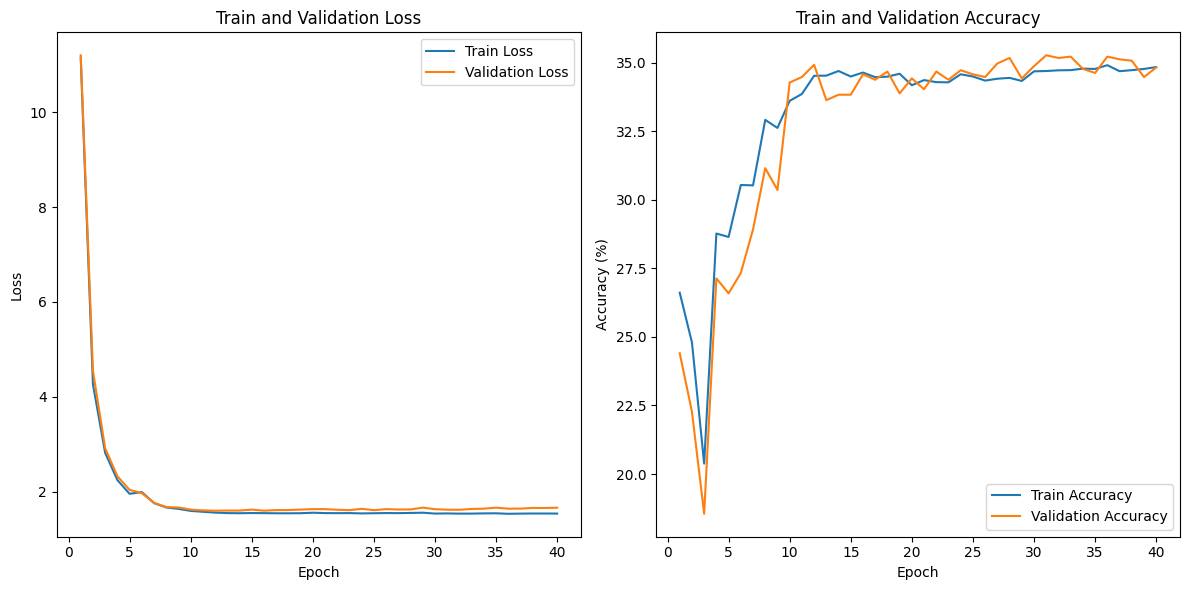

In [11]:
res = pd.DataFrame(history)
plot(res)

In [12]:
evaluate(model, test_dataset, device)

(34.32539682539682, 1.653055194824461)

### Train LSTM using embedding

In [13]:
%%time


class LSTMNetwork(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        self.embeddings = nn.Embedding(len(processor.vocab), 32)
        self.lstm = nn.LSTM(32, 64, num_layers=2, batch_first=True)
        self.fc = nn.Linear(64, n_class)

    def forward(self, features):
        features = features.type(torch.long)
        emb = self.embeddings(features)
        # print(emb.shape)
        out, _ = self.lstm(emb)
        out = self.fc(out[:, -1, :])  # Use the output from the last time step
        return out


model_lstm = LSTMNetwork(n_class=6).to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_lstm.parameters(), lr=0.01)

# Assuming trainer is a function that handles the training loop
history = trainer(
    model_lstm,
    epochs=40,
    device=device,
    train_data=train_dataset,
    val_data=val_dataset,
    criterion=criterion,
    optimizer=optimizer,
)

100%|██████████| 500/500 [00:14<00:00, 34.85it/s]


Epoch: 1/40
Training ---|  Accuracy: 33.51 Loss: 1.57937
Validation ---|  Accuracy: 35.37 Loss: 1.58507


100%|██████████| 500/500 [00:13<00:00, 35.82it/s]


Epoch: 2/40
Training ---|  Accuracy: 33.51 Loss: 1.57680
Validation ---|  Accuracy: 35.17 Loss: 1.58367


100%|██████████| 500/500 [00:14<00:00, 35.19it/s]


Epoch: 3/40
Training ---|  Accuracy: 33.51 Loss: 1.56029
Validation ---|  Accuracy: 35.07 Loss: 1.59438


100%|██████████| 500/500 [00:14<00:00, 35.15it/s]


Epoch: 4/40
Training ---|  Accuracy: 33.51 Loss: 1.56110
Validation ---|  Accuracy: 35.37 Loss: 1.58777


100%|██████████| 500/500 [00:13<00:00, 36.00it/s]


Epoch: 5/40
Training ---|  Accuracy: 29.36 Loss: 1.53905
Validation ---|  Accuracy: 27.23 Loss: 1.60230


100%|██████████| 500/500 [00:13<00:00, 35.80it/s]


Epoch: 6/40
Training ---|  Accuracy: 34.02 Loss: 1.51633
Validation ---|  Accuracy: 34.18 Loss: 1.66881


100%|██████████| 500/500 [00:13<00:00, 36.11it/s]


Epoch: 7/40
Training ---|  Accuracy: 34.07 Loss: 1.51343
Validation ---|  Accuracy: 34.23 Loss: 1.61249


100%|██████████| 500/500 [00:14<00:00, 35.21it/s]


Epoch: 8/40
Training ---|  Accuracy: 34.36 Loss: 1.49862
Validation ---|  Accuracy: 33.93 Loss: 1.63482


100%|██████████| 500/500 [00:13<00:00, 35.72it/s]


Epoch: 9/40
Training ---|  Accuracy: 35.79 Loss: 1.47721
Validation ---|  Accuracy: 30.80 Loss: 1.62847


100%|██████████| 500/500 [00:14<00:00, 35.31it/s]


Epoch: 10/40
Training ---|  Accuracy: 41.42 Loss: 1.42300
Validation ---|  Accuracy: 36.90 Loss: 1.60452


100%|██████████| 500/500 [00:13<00:00, 35.81it/s]


Epoch: 11/40
Training ---|  Accuracy: 46.42 Loss: 1.35364
Validation ---|  Accuracy: 39.24 Loss: 1.58872


100%|██████████| 500/500 [00:14<00:00, 35.05it/s]


Epoch: 12/40
Training ---|  Accuracy: 55.26 Loss: 1.19203
Validation ---|  Accuracy: 47.27 Loss: 1.44915


100%|██████████| 500/500 [00:15<00:00, 32.84it/s]


Epoch: 13/40
Training ---|  Accuracy: 62.44 Loss: 1.00371
Validation ---|  Accuracy: 55.26 Loss: 1.23569


100%|██████████| 500/500 [00:14<00:00, 35.47it/s]


Epoch: 14/40
Training ---|  Accuracy: 68.04 Loss: 0.83424
Validation ---|  Accuracy: 60.32 Loss: 1.08314


100%|██████████| 500/500 [00:14<00:00, 35.13it/s]


Epoch: 15/40
Training ---|  Accuracy: 75.03 Loss: 0.68185
Validation ---|  Accuracy: 62.95 Loss: 0.99547


100%|██████████| 500/500 [00:14<00:00, 35.46it/s]


Epoch: 16/40
Training ---|  Accuracy: 79.72 Loss: 0.55475
Validation ---|  Accuracy: 68.80 Loss: 0.86466


100%|██████████| 500/500 [00:14<00:00, 34.37it/s]


Epoch: 17/40
Training ---|  Accuracy: 84.66 Loss: 0.43740
Validation ---|  Accuracy: 71.03 Loss: 0.77955


100%|██████████| 500/500 [00:14<00:00, 34.15it/s]


Epoch: 18/40
Training ---|  Accuracy: 87.17 Loss: 0.37038
Validation ---|  Accuracy: 75.00 Loss: 0.71696


100%|██████████| 500/500 [00:15<00:00, 32.94it/s]


Epoch: 19/40
Training ---|  Accuracy: 89.62 Loss: 0.30504
Validation ---|  Accuracy: 77.03 Loss: 0.64036


100%|██████████| 500/500 [00:16<00:00, 30.70it/s]


Epoch: 20/40
Training ---|  Accuracy: 91.60 Loss: 0.24801
Validation ---|  Accuracy: 78.97 Loss: 0.59275


100%|██████████| 500/500 [00:15<00:00, 32.00it/s]


Epoch: 21/40
Training ---|  Accuracy: 92.49 Loss: 0.21832
Validation ---|  Accuracy: 80.90 Loss: 0.59275


100%|██████████| 500/500 [00:15<00:00, 33.21it/s]


Epoch: 22/40
Training ---|  Accuracy: 92.74 Loss: 0.20222
Validation ---|  Accuracy: 80.16 Loss: 0.57979


100%|██████████| 500/500 [00:15<00:00, 32.82it/s]


Epoch: 23/40
Training ---|  Accuracy: 94.12 Loss: 0.17485
Validation ---|  Accuracy: 83.33 Loss: 0.53111


100%|██████████| 500/500 [00:15<00:00, 32.24it/s]


Epoch: 24/40
Training ---|  Accuracy: 94.40 Loss: 0.16344
Validation ---|  Accuracy: 82.39 Loss: 0.55032


100%|██████████| 500/500 [00:15<00:00, 32.04it/s]


Epoch: 25/40
Training ---|  Accuracy: 94.51 Loss: 0.15399
Validation ---|  Accuracy: 82.74 Loss: 0.55383


100%|██████████| 500/500 [00:15<00:00, 31.26it/s]


Epoch: 26/40
Training ---|  Accuracy: 94.73 Loss: 0.14490
Validation ---|  Accuracy: 83.83 Loss: 0.52451


100%|██████████| 500/500 [00:15<00:00, 31.60it/s]


Epoch: 27/40
Training ---|  Accuracy: 95.38 Loss: 0.12445
Validation ---|  Accuracy: 84.82 Loss: 0.49856


100%|██████████| 500/500 [00:16<00:00, 30.17it/s]


Epoch: 28/40
Training ---|  Accuracy: 94.56 Loss: 0.14741
Validation ---|  Accuracy: 83.63 Loss: 0.52185


100%|██████████| 500/500 [00:16<00:00, 30.85it/s]


Epoch: 29/40
Training ---|  Accuracy: 95.77 Loss: 0.11810
Validation ---|  Accuracy: 84.42 Loss: 0.50316


100%|██████████| 500/500 [00:17<00:00, 29.18it/s]


Epoch: 30/40
Training ---|  Accuracy: 96.10 Loss: 0.11227
Validation ---|  Accuracy: 85.86 Loss: 0.43189


100%|██████████| 500/500 [00:17<00:00, 28.11it/s]


Epoch: 31/40
Training ---|  Accuracy: 95.84 Loss: 0.11267
Validation ---|  Accuracy: 84.62 Loss: 0.47559


100%|██████████| 500/500 [00:18<00:00, 26.94it/s]


Epoch: 32/40
Training ---|  Accuracy: 96.09 Loss: 0.10500
Validation ---|  Accuracy: 84.82 Loss: 0.49263


100%|██████████| 500/500 [00:19<00:00, 25.20it/s]


Epoch: 33/40
Training ---|  Accuracy: 96.50 Loss: 0.09494
Validation ---|  Accuracy: 86.31 Loss: 0.45300


100%|██████████| 500/500 [00:21<00:00, 23.70it/s]


Epoch: 34/40
Training ---|  Accuracy: 96.46 Loss: 0.09583
Validation ---|  Accuracy: 85.91 Loss: 0.44665


100%|██████████| 500/500 [00:21<00:00, 23.49it/s]


Epoch: 35/40
Training ---|  Accuracy: 96.60 Loss: 0.09595
Validation ---|  Accuracy: 86.36 Loss: 0.47578


100%|██████████| 500/500 [00:21<00:00, 22.80it/s]


Epoch: 36/40
Training ---|  Accuracy: 97.06 Loss: 0.07856
Validation ---|  Accuracy: 85.32 Loss: 0.50369


100%|██████████| 500/500 [00:22<00:00, 22.42it/s]


Epoch: 37/40
Training ---|  Accuracy: 97.06 Loss: 0.08100
Validation ---|  Accuracy: 87.00 Loss: 0.45271


100%|██████████| 500/500 [00:24<00:00, 20.61it/s]


Epoch: 38/40
Training ---|  Accuracy: 97.19 Loss: 0.07729
Validation ---|  Accuracy: 86.11 Loss: 0.47965


100%|██████████| 500/500 [00:24<00:00, 20.40it/s]


Epoch: 39/40
Training ---|  Accuracy: 97.21 Loss: 0.07475
Validation ---|  Accuracy: 87.20 Loss: 0.46553


100%|██████████| 500/500 [00:25<00:00, 19.32it/s]


Epoch: 40/40
Training ---|  Accuracy: 97.38 Loss: 0.07172
Validation ---|  Accuracy: 87.70 Loss: 0.43013
CPU times: user 14min 24s, sys: 5.74 s, total: 14min 30s
Wall time: 14min 43s


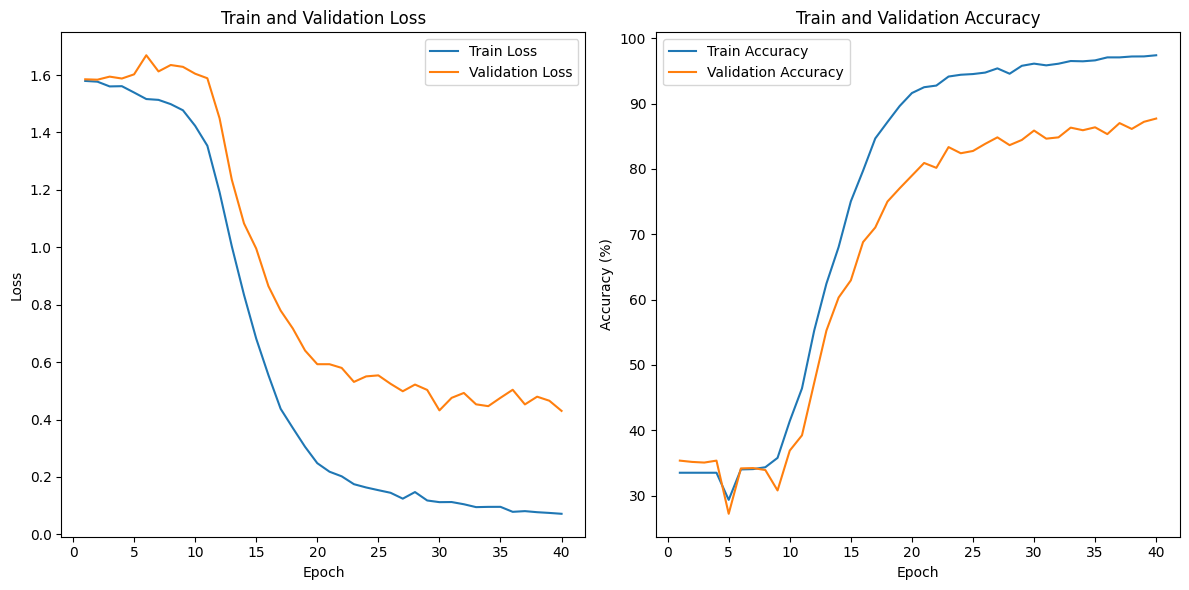

In [14]:
res = pd.DataFrame(history)
plot(res)

In [19]:
evaluate(model_lstm, test_dataset, device="cpu")

(86.60714285714286, 0.4639430692389844)